# Dense network demonstrations

## Getting started with this demo

To get started with this demo, please create an environment based on ``demo-requirements.conda.yaml``. See the ``README`` for instructions.

The ``torch_tools.DenseNetwork`` model can be used for classification or regression.

Here we will use it for a classification problem. We need:

* Some data:
    * For the classification and regression examples we will use some datasets available from scikit-learn.
    * For more information, see the [data set's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).
* Some data loading utilities:
    * We need to load the data using a ``Dataset`` and ``DataLoader``.
* A model:
    * We will instantiate the model shortly.
* A loss function.
* An optimiser to fit the model with.

## Classification example


Scikit learn has a bunch of available datasets that we can select an example from. We will use the breast cancer classification dataset. These data include physical measurements from various tumours, and their status as malignant or normal.

Let's grab the data from scikit-learn:

In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True).frame

valid_split = data.groupby("target").sample(frac=0.2, random_state=123)

# The train split contains the items which were not randomly selected for
# validation
train_split = data.loc[~data.index.isin(valid_split.index)]


The training and validation datasets are pandas ``DataFrame`` objects, holding various physical characteristics of the tumours, along with their classifications.

In [2]:
print(valid_split)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
414       15.130         29.81           96.71      719.5          0.08320   
432       20.180         19.54          133.80     1250.0          0.11330   
449       21.100         20.52          138.10     1384.0          0.09684   
260       20.310         27.06          132.90     1288.0          0.10000   
492       18.010         20.56          118.40     1007.0          0.10010   
..           ...           ...             ...        ...              ...   
472       14.920         14.93           96.45      686.9          0.08098   
314        8.597         18.60           54.09      221.2          0.10740   
421       14.690         13.98           98.22      656.1          0.10310   
376       10.570         20.22           70.15      338.3          0.09073   
484       15.730         11.28          102.80      747.2          0.10430   

     mean compactness  mean concavity  mean concave points  mea

Now we have downloaded the breast cancer dataset from scikit-learn and split the data into a training and validation set. Conventially, one should split the data into a training, validation and testing set, but since this is only a simple example, with a very small dataset, we only use a training and a validation set.

As a matter of convenience, let's grab a list of the keys for accessing the data and targets separately.

In [3]:
data_keys = list(filter(lambda x: x != "target", data.keys()))
target_keys = ["target"]

print(data_keys)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


Now, we create ``DataSet`` objects for the training and validation sets.

In [4]:
import torch
from torchvision.transforms import Compose

from torch_tools import DataSet

train_set = DataSet(
    inputs=tuple(train_split[data_keys].to_numpy()),
    targets=tuple(train_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(2)[x].squeeze()]),
)

valid_set = DataSet(
    inputs=tuple(valid_split[data_keys].to_numpy()),
    targets=tuple(valid_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(2)[x].squeeze()]),
)

The ``DataSet`` objects are iterables which yield input–target pairs (as ``torch.Tensor``s):

In [5]:
for input_item, target in valid_set:
    print(input_item.shape, target.shape)

(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torch.Size([2])
(30,) torc

While PyTorch ``Dataset``s generally return single input-target pairs, we normally supply data to neural networks in mini-batches. The PyTorch way to achieve this is use a ``DataLoader`` object.

In [6]:
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([3, 30]) torch.Size([3, 2])


Now we can that each input is a ``Tensor`` of shape ``(10, 30)`` because each input has 30 features and we use a batch size of ten. The targets are simply one-hot-encoded vectors giving the binary classification of each input item.

Before we train the model. we need to decide whether we want to train the model on the GPU or the CPU. PyTorch has a way of managing this:

In [7]:
from torch.cuda import is_available
DEVICE = "cuda" if is_available() else "cpu"
print(DEVICE)

cpu


Now we have the data, we need a model, loss function and optimiser. Let's set these things up:

- For our choice of model, we can use the ``torch_tools.DenseNetwork`` model.
- For the loss function, we choose the (fairly) standard binary-cross-entropy.
  - See PyTorch's [BCELoss docs](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).
- For our optimiser, we will use the (again fairly standard) Adam optimiser.
  - See PyTorch's [Adam optimiser docs](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [8]:
from torch.nn import BCELoss
from torch.optim import Adam

from torch_tools import DenseNetwork


loss_func = BCELoss(reduction="sum")

model = DenseNetwork(
    in_feats=30,
    out_feats=2,
    hidden_sizes=(16, 8),
    input_dropout=0.1,
    input_bnorm=True,
    hidden_dropout=0.25,
).to(DEVICE)
print(model)


optimiser = Adam(model.parameters(), lr=1e-4)

DenseNetwork(
  (0): InputBlock(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=8, out_features=2, bias=True)
  )
)


Let's write functions for training and validating single epochs

In [9]:
from torch.nn import Module
from torch import no_grad


def train_one_epoch(
    model: Module,
    loss_func: BCELoss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        The model we want to train.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    optim : Adam
        Adam optimiser.
    train_loader : DataLoader
        Training dataloader.

    Returns
    -------
    mean_loss: float
        Mean loss per batch.
    accuracy : float
        Accuracy over the epoch.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        # Move the inputs and targets from the cpu to the gpu.
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)
        # Zero the gradients.
        optim.zero_grad()
        # Predict using the batch of inputs.
        prediction = model(batch).softmax(dim=1)
        # Compute the loss
        loss = loss_func(prediction, targets)
        # Backpropagate (differentiate the parameters wrt the loss)
        loss.backward()
        # Step the parameters
        optim.step()
        # Record the loss
        running_loss += loss.item()
        # Record the number of correctly classified items
        correct += (
            (prediction.detach().argmax(dim=1) == targets.argmax(dim=1)).sum().cpu()
        )

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: BCELoss,
    valid_loader: DataLoader,
):
    """Validate single epoch.

    Parameters
    ----------
    model : Module
        The model to validate.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    valid_loader : DataLoader
        Validation data loader.

    Returns
    -------
    float
        Mean loss per item.
    accuracy : float
        Accuracy over the epoch.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        # Move the inputs and targets from the cpu to the gpu.
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)
        # Predict using the batch of inputs
        pred = model(batch).softmax(dim=1)
        # Calculate the loss
        loss = loss_func(pred, targets)
        # Record the number of correctly classified items
        correct += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().cpu()
        # Record the loss
        running_loss += loss.item()

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now, we train!

In [10]:
metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
}

for epoch in range(200):
    train_loss, train_acc = train_one_epoch(
        model,
        loss_func,
        optimiser,
        train_loader,
    )
    valid_loss, valid_acc = validate_one_epoch(model, loss_func, valid_loader)

    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_acc"].append(valid_acc)

Now that the model is trained, we can plot the ``metrics`` dictionary we have populated.

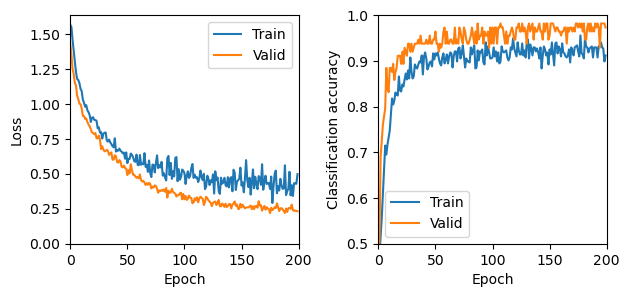

In [11]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2)
axes[0].plot(metrics["train_loss"], label="Train")
axes[0].plot(metrics["valid_loss"], label="Valid")


axes[1].plot(metrics["train_acc"], label="Train")
axes[1].plot(metrics["valid_acc"], label="Valid")

axes[0].set_ylim(bottom=0.0)
axes[1].set_ylim(bottom=0.5, top=1.0)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Classification accuracy")


for axis in axes.ravel():
    axis.set_xlabel("Epoch")
    axis.set_xlim(left=0.0, right=len(metrics["train_acc"]))
    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )
    axis.legend()


figure.tight_layout()

plt.show()

With no prior knowledge of this dataset, this seems like reasonable performance.